# <font color='navy'> <b> Parametrická simulácia  </b></font>

Pre podporu širšej práce so simulátorom **ngspice** pre rozhranie medzi Pythonom / Jupyter-Notebook-om a prostredím **KiCad** bola vytvorená podporná knižnica *kSim*, ktorú tvorí jednoduchý predprocesor napísaný v Pythone pre simulátor *ngspice* (alebo rozsiahlejší *xyce*). Predprocesor umožnuje interaktívne riadenie simulácie, konverzie dát do prostredia Pythonu a spracovanie výsledkov simulácie v prostredí Notebooku s pomocou štandarných knižníc. 

Výhodou uvedeného konceptu je

* možnosť tvorby interaktívnych textov (popis elektronického obvodu, vzťahy, výpočty) s následnou podporou simulácie 
* možnosť tvorby technických dokumentov pre návrh a výpočty preddefinovaných obvodových zapojení (filtre a pod.)
* celý koncept je open-source a nie je zaťažený licenčnými poplatkami

Vlastnú knižnicu *kSim* je možné využívať aj mimo prostredia notebooku, najmä v prípadoch, ak potrebujeme opakovane prepočítavať elektronické zapojenie s modifikáciou jeho parametrov alebo pomocou algoritmov z knižníc Pythonu optimalizovať jeho vlastnosti.

Parametrická simulácia umožňuje simuláciu obvodu so zmenou hodnôt prvkov zapojenia bez potreby editovania zapojenia alebo netlistu, pričom je možné meniť hodnoty jedného alebo viacerých parametrov. V štandardnej syntaxi SPICE je pre definovanie hodnoty parametra vyhradená direktíva .PARAMS. V nasledujúcom obvode sú hodnoty prvkov obvodu zadané matematickými vzťahmi s použitím niekoľkých parametrov.  


## <font color='purple'> <b> Vytvorenie parametrického obvodu </b></font>

Obvod vytvoríme pomocou štandardnej knižnice *Simulation-SPICE*, pre parametre ktoré budeme meniť nezadáme hodnotu, ale pomenovaný parameter.

<img src="./examples/0055_param_sim/0055_param_sim.png" width="500">

Pretože parametre je možné meniť pomocou programu, otvára sa nám množstvo možností, ako túto vlastnosť využiť, napríklad s použitím optimalizačných metód môžeme zmenou hodnôt parametrov vyhľadať také ich hodnoty, aby obvod spĺňal vopred definované vlastnosti.

## <font color='purple'> <b> Simulácia </b></font>

Netlist vygenerujeme zo zapojenia priamo v editore zapojenia alebo pomocou utility *kicad-cli* vo formáte SPICE.

In [2]:
import sys
sys.path.append('./py')  
from ksim import *      

g = kSim('./examples/0055_param_sim/0055_param_sim.cir')                 

Nastavenie hodnôt parametrov v *kSim* je možné pomocou metódy *setPAR*, hodnotu je možné zadať v numerickom ako aj v textovom tvare s dodržaním formátu SPICE. Parametricky je definovaný aj typ simulácie a frekvenčné pásmo. Zmena parametra je realizovaná jednoduchou zámenou textu v netliste.

In [3]:
g.setPAR('R',20.2e3)      # numericka hodnota parametru 
g.setPAR('C', '0.1uF')   # textova hodnota parametru
g.setPAR('w', 0.055)

g.setAC(10, 1000, number=1000, stype='DEC' )
g.sim()

[q for q in g.yData]     # zoznam simulovanych hodnot

['v(net-_c2-pad2_)', 'v(net-_c1-pad2_)', 'v(net-_c1-pad1_)', 'v(out)', 'i(v1)']

## <font color='purple'> <b> Zobrazenie dát </b></font>

Simulované dáta môžeme priamo využiť pre vytvorenie dátového objektu z knižnice *Pandas*. Hodnoty frekvencie ako nezávislej premennej môžeme priradiť ako index pre dátový objekt. 

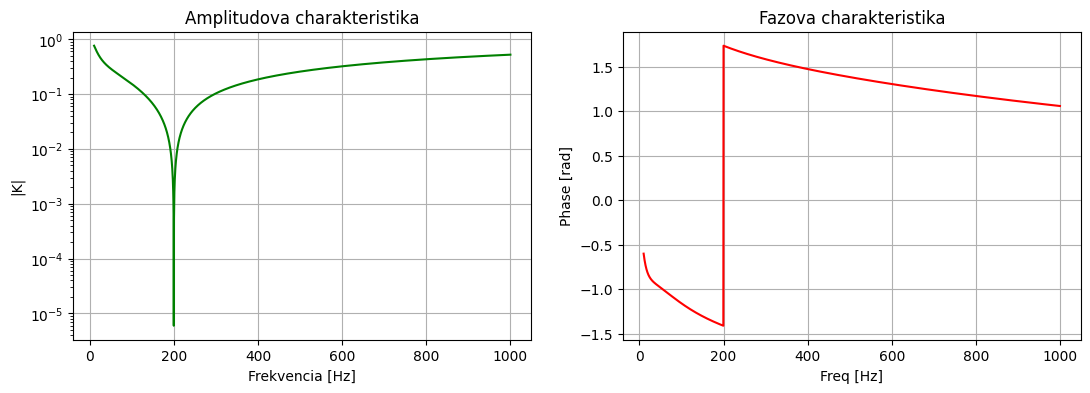

In [4]:
%matplotlib inline
import pylab as plt
import pandas as pd
import numpy as np

s = pd.DataFrame(g.yData)  # vytvorenie datoveho objektu
s.index = g.xData          # priradenie indexu dat - frekvencia

fig = plt.figure(figsize=(13, 4)) 

p1 = plt.subplot(121)
p1.semilogy(s.index, np.abs(s['v(out)']), 'g-')
p1.set_xlabel('Frekvencia [Hz]')
p1.set_ylabel('|K|')
p1.set_title('Amplitudova charakteristika')
p1.grid()

p2 = plt.subplot(122)
p2.plot(s.index,  np.angle(s['v(out)'], deg=False)  ,'r-')
p2.set_xlabel('Freq [Hz]')
p2.set_ylabel('Phase [rad]')
p2.set_title('Fazova charakteristika')
p2.grid()
plt.show()

## <font color='purple'> <b>  Simulácia s programovou zmenou parametra  </b></font>

Parametre simulácie môžeme substituovať štandardnými premennými v programe.

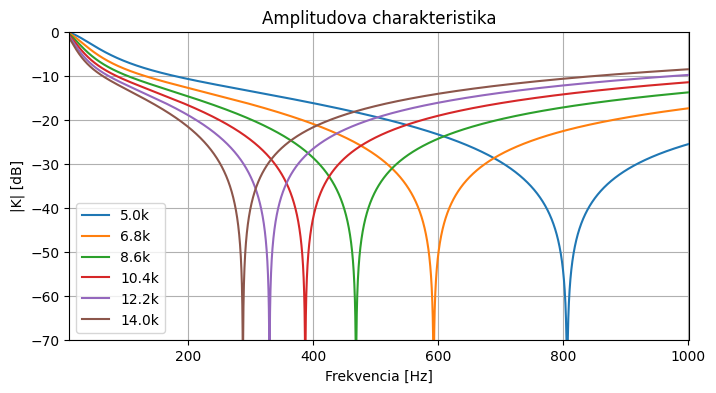

In [5]:
g.setPAR('R', 8.2e3)      # numericka hodnota parametru 
g.setPAR('C', '0.1uF')   # textova hodnota parametru
g.setPAR('w', 0.055)

g.setAC(10, 1000, number=10000, stype='DEC' )

fig = plt.figure(figsize=(8, 4)) 

for r in linspace(5e3, 14e3, 6):
    g.setPAR('R', r) 
    g.sim()
    plt.plot(g.xData, log10(np.abs(g.yData['v(out)']))*20, label=str(r/1e3)+'k' )
    plt.ylim(-70, 0)
    plt.xlim(g.xData[0], g.xData[-1])

plt.legend()
plt.xlabel('Frekvencia [Hz]')
plt.ylabel('|K| [dB]')
plt.title('Amplitudova charakteristika')
plt.grid()   
plt.show()